# Sanity Check of the Borrowing Dataset

This notebook is used to explore the provided borrowing dataset, identify potential issues, and build an initial understanding of the availabe data.
The goal is to analyse the data quality and highlight problems such as missing entries, inconsistent values, or unusual patterns.

The dataset originates form a libary management system and contains information about individual borrowing transactions, such as checkout time, return time, loan durration, user category, media type, and bibliographic details.

The data is stored in a seperate CSV file for each year. Data is availabe from the beginning of 2019 until November 24, 2025.

The amount of data differs over the years:

,year,entries
0,2019,393533
1,2020,336369
2,2021,253053
3,2022,306577
4,2023,378329
5,2024,381935
6,2025,357814


Total number of borrowing entries from 2019 to 2025: 2407610


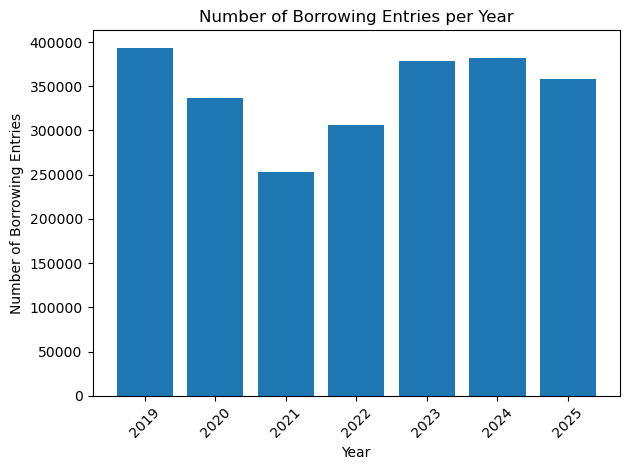

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

data_dir = Path('../data/raw/borrowings')

files = sorted(data_dir.glob('borrowings_*.csv'))

yearly_counts = {}

for file in files:
    df = pd.read_csv(file, sep=';', quotechar='"', encoding='utf-8')
    year = file.stem.split('_')[-1]
    yearly_counts[year] = len(df)

count_df = pd.DataFrame(
    {'year': list(yearly_counts.keys()), 'entries': list(yearly_counts.values())}
).sort_values(by='year')

display(count_df)

tototal_entries = count_df['entries'].sum()
print(f'Total number of borrowing entries from 2019 to 2025: {tototal_entries}')

# plot
plt.figure()
plt.bar(count_df['year'], count_df['entries'])
plt.xlabel('Year')
plt.ylabel('Number of Borrowing Entries')
plt.title('Number of Borrowing Entries per Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We want to look at the the data for the entire period, so it is merged into one file: "../data/processed/borrowings_2019_2025.csv"

In [2]:
all_dfs = []

for file in files:
    df_year = pd.read_csv(file, sep=';', quotechar='"', encoding='utf-8')
    all_dfs.append(df_year)

df_all = pd.concat(all_dfs, ignore_index=True)

print("Merged shape: ", df_all.shape)

output_file = Path('../data/processed/borrowings_2019_2025.csv')
output_file.parent.mkdir(parents=True, exist_ok=True)
df_all.to_csv(output_file, index=False, sep=';', quotechar='"', encoding='utf-8')
print(f'Merged data saved to {output_file}')

Merged shape:  (2407610, 16)
Merged data saved to ../data/processed/borrowings_2019_2025.csv


## Dataset Overview

Each row in the dataset represents a single borrowing transaction:

- 'issue_id': 
- 'Ausleihdatum/Uhrzeit':
- 'Rückgabedatum/Uhrzeit':
- 'Leihdauer':
- 'Anzahl_Verlängerungen':
- 'Verspätet':
- 'Tage_zu_spät':
- 'Sammlungszeichen/CCODE':
- 'Medientyp':
- 'Barcode'
- 'Titel' 
- 'Autor':
- 'ISBN':
- 'Interessenkreis':
- 'Benuterkategorie':
- 'Benutzer-Systemnummer':

In [3]:
df.columns.tolist()

['issue_id',
 'Ausleihdatum/Uhrzeit',
 'Rückgabedatum/Uhrzeit',
 'Leihdauer',
 'Anzahl_Verlängerungen',
 'Verspätet',
 'Tage_zu_spät',
 'Sammlungszeichen/CCODE',
 'Medientyp',
 'Barcode',
 'Titel',
 'Autor',
 'ISBN',
 'Interessenkreis',
 'Benutzerkategorie',
 'Benutzer-Systemnummer']

## Missing Values and Completness

In this step, we examine the the completeness of the dataset by identifying missing or empty values in each column.
Missing values can indicate issues such as incompletete records or irregular entries in the libary system.

Understanding which values are affected helps assess overall data quality and guides later data cleaning steps.

We inspect both:
- standard missing values ('NaN')
- empty strings (e.g., incomplete text fields like title, author, ISBN)

This provides a clear picture of how reliable each column is across all years.

In [4]:
missing_percent = (df_all.isna().mean().sort_values(ascending=False) * 100)

print("Percentage of missing values per column:")
display(missing_percent)

Percentage of missing values per column:


Autor                     39.050843
Interessenkreis           37.437583
ISBN                      34.025154
Sammlungszeichen/CCODE    17.393722
Titel                     17.330880
Medientyp                 17.330714
Barcode                   17.330506
Benutzerkategorie          6.782909
Benutzer-Systemnummer      6.782909
Rückgabedatum/Uhrzeit      2.026325
Leihdauer                  2.026325
Tage_zu_spät               2.026325
issue_id                   0.000000
Ausleihdatum/Uhrzeit       0.000000
Anzahl_Verlängerungen      0.000000
Verspätet                  0.000000
dtype: float64

## Checking Loan and Return Dates

Here we check if the loan and return dates make sense and if the loan period is correctly recorded in the CSV file.
We calculate the loan duration by subtracting the loan date from the return date and using standard rounding to get whole days.
We show how many loan periods differ from the CSV file and by how many days. We also check if there are negative time periods or identical loan and return timestamps.

In [5]:
# Konvertierung der Datums-Spalten
df_all['Ausleihdatum/Uhrzeit'] = pd.to_datetime(df_all['Ausleihdatum/Uhrzeit'], errors='coerce')
df_all['Rückgabedatum/Uhrzeit'] = pd.to_datetime(df_all['Rückgabedatum/Uhrzeit'], errors='coerce')

total_rows = len(df_all)

# Offene Ausleihen
open_loans_mask = df_all['Rückgabedatum/Uhrzeit'].isna() & df_all['Ausleihdatum/Uhrzeit'].notna()
open_loans_count = open_loans_mask.sum()

# Zurückgegebene Ausleihen
complete_mask = df_all['Ausleihdatum/Uhrzeit'].notna() & df_all['Rückgabedatum/Uhrzeit'].notna()

# Exakte Zeitberechnung mit Auf und Abrunden je nach Zeitdifferenz
df_all.loc[complete_mask, 'Leihdauer_neu'] = np.round(
    (df_all.loc[complete_mask, 'Rückgabedatum/Uhrzeit'] - df_all.loc[complete_mask, 'Ausleihdatum/Uhrzeit']).dt.total_seconds() / 86400
).astype(int)

# Ändere orginal Leihdauerstrings zu numerischen Werten und speicher in neuer Spalte
df_all['Leihdauer_num'] = pd.to_numeric(df_all.get('Leihdauer'), errors='coerce')

# Vergleichsmaske: nur vollständige Datensätze mit numerischer Leihdauer
compare_mask = complete_mask & df_all['Leihdauer_num'].notna()

# Differenz in Tagen zwischen berechneter und Leihdauer aus CSV
df_all.loc[compare_mask, 'Diff_in_Tagen'] = df_all.loc[compare_mask, 'Leihdauer_neu'] - df_all.loc[compare_mask, 'Leihdauer_num']

# Zählen der Fälle mit positiver, negativer und null Differenz
pos = (df_all['Diff_in_Tagen'] > 0).sum()
neg = (df_all['Diff_in_Tagen'] < 0).sum()
zero = (df_all['Diff_in_Tagen'] == 0).sum()

# Ausgabe der Ergebnisse
print("=== Loan Duration ===")
print(f"Total rows: {total_rows}")
print(f"Returned loans: {complete_mask.sum()} ({complete_mask.sum()/total_rows:.2%})")
print(f"Open loans: {open_loans_count} ({open_loans_count/total_rows:.2%})")

print("\n=== Comparison: loan duration CSV vs. calculated ===")
print(f"Comparable cases: {compare_mask.sum()}")
print(f" - Calculated longer: {pos} ({(pos/max(compare_mask.sum(),1)):.2%})")
print(f" - Both equal: {zero} ({(zero/max(compare_mask.sum(),1)):.2%})")
print(f" - Calculated shorter: {neg} ({(neg/max(compare_mask.sum(),1)):.2%})")

# Kompakte, lesbare Tabelle der Differenzen
Diff_in_Tagen_counts = df_all.loc[compare_mask, 'Diff_in_Tagen'].value_counts().sort_index()

Diff_in_Tagen_summary = (
    Diff_in_Tagen_counts.rename('Anzahl')
    .to_frame()
    .assign(Anteil=lambda x: x['Anzahl'] / max(compare_mask.sum(), 1))
    .reset_index()
    .rename(columns={'index': 'Differenz (berechnet - Original)'})
)

print("\n=== Distribution of difference ===")
display(Diff_in_Tagen_summary.head(15).style.format({'Anteil': '{:.2%}'}))

# Roh-Differenz für Zusatzanalysen
delta_raw = df_all.loc[complete_mask, 'Rückgabedatum/Uhrzeit'] - df_all.loc[complete_mask, 'Ausleihdatum/Uhrzeit']
zero_day = (delta_raw.dt.days == 0).sum()
zero_exact_ts = (delta_raw.dt.total_seconds() == 0).sum()

print("\n=== Edge Cases ===")
print(f"Same calendar day (but different times): {zero_day}")
print(f"Exactly identical timestamp: {zero_exact_ts}")


# Prüfung auf negative Zeitdifferenzen (Datenfehler) im Datensatz
negative_mask = delta_raw.dt.total_seconds() < 0
negative_count = negative_mask.sum()

print("\n=== Data Quality Check ===")
print(f"Negative time differences (data errors): {negative_count}")

# Gibt Beispiele für negative Zeitdifferenzen aus, falls vorhanden
if negative_count > 0:
    neg_examples = df_all.loc[complete_mask].loc[negative_mask, [
        'Ausleihdatum/Uhrzeit','Rückgabedatum/Uhrzeit','Leihdauer_num','Leihdauer_neu','Diff_in_Tagen'
    ]].head(15)
    print("\nExamples of negative cases (sample):")
    display(neg_examples)

=== Loan Duration ===
Total rows: 2407610
Returned loans: 2358824 (97.97%)
Open loans: 48786 (2.03%)

=== Comparison: loan duration CSV vs. calculated ===
Comparable cases: 2358824
 - Calculated longer: 195 (0.01%)
 - Both equal: 2357887 (99.96%)
 - Calculated shorter: 742 (0.03%)

=== Distribution of difference ===


,Diff_in_Tagen,Anzahl,Anteil
0,-1.000000,742,0.03%
1,0.000000,2357887,99.96%
2,1.000000,195,0.01%



=== Edge Cases ===
Same calendar day (but different times): 45638
Exactly identical timestamp: 0

=== Data Quality Check ===
Negative time differences (data errors): 0
